In [1]:
import conf

conf done!


<div class="maintitle">
    <h2> Métodos Multicriterio Orientados al Tratamiento Automático de Datos</h2>
    <h3 class="subtitle">Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
    <span>FaMAF-UNC, 2023 </span>
</div>

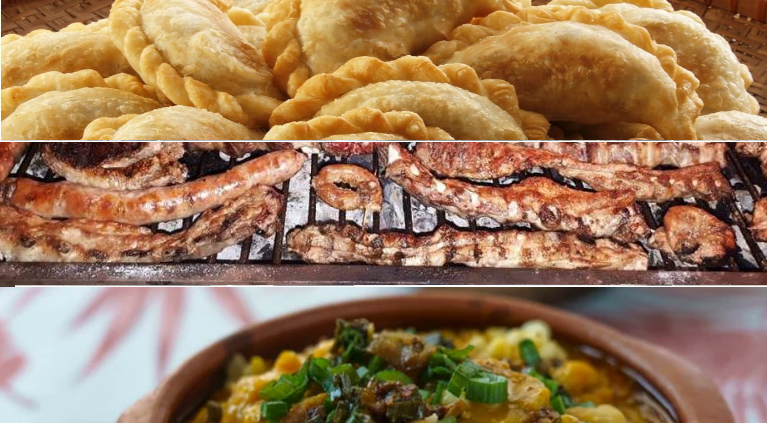

**Docentes:**
- Dr. Juan B Cabral (FaMAF-UNC, CONAE, IATE-OAC-CONICET)
- Mg. Nadia Luczywo (FCE-UNC)

## Clase 2

- Cálculo automático de pesos: Desvio, Entropía y CRITIC.
- Mátodos basados en similaridad: TOPSIS.
- Escuela Francesa: ELECTRE-I, ELECTRE-II.
- Comparando resultados.
- SKCriteria internals.


## Calculo automático de pesos

- Los pesos *son* meter sesgos a los criterios de tal forma, representen las preferencias de un descisor.
- En un mundo ideal (y en el caso de pocos datos) seria bueno que los que "paguen" por la decision sean los que proveean esos pesos.
- La realidad es otra (y sobre todo como analista/cientifico de datos):

    1. Los datos que se encuentran en internet suelen tener bastante mas dimensionalidad que unos pocos criterios.
    2. Es naive asumir que todos los criterios tienen la misma importancia.
    3. No siempre se dispone de un experto.

## Nota 1:

- Algunas librerias manejan el concepto de "*weights/profit*" vs "*cost*". 
- SKCriteria utiliza unicamente "*weights/profit*" en cooncordancia de que se prefiere $maximizar$.

## Nota 2:

- Es recomendable asignar pesos de manera automática en dos lugares:
    - **justo antes** de ejecutar la función de agregación. 
    - **justo antes** de empezar a masajear los datos. 

## El ejemplo

Vamos a usar el mismo ejemplo de la clase 1.

In [2]:
import skcriteria as skc
from skcriteria import datasets

dm = datasets.load_simple_stock_selection()
dm

ROE[▲ 2.0]  CAP[▲ 4.0]  RI[▼ 1.0]
PE           7           5         35
JN           5           4         26
AA           5           6         28
FX           3           4         36
MM           1           7         30
GN           5           8         30
[6 Alternatives x 3 Criteria]

Ahora pongamos todos los pesos en `1` para empezar a jugar

In [3]:
dm = dm.copy(weights=[1, 1, 1])
dm

ROE[▲ 1.0]  CAP[▲ 1.0]  RI[▼ 1.0]
PE           7           5         35
JN           5           4         26
AA           5           6         28
FX           3           4         36
MM           1           7         30
GN           5           8         30
[6 Alternatives x 3 Criteria]

## `skcriteria.preprocessing.weighters`

El modulo `weighters` posee transformadores para alterar de manera automática los pesos

Los implementados son:

- `EqualWeighter`: Aproach naive - Todos los pesos iguales.
- `StdWeighter`: Buscar cual es el peso que mas explica los datos.
- `EntropyWeighter`: El criterio con mas información.
- `Critic`: Lo vemo' ma' adelante.


In [4]:
from skcriteria.preprocessing import weighters

## `skcriteria.preprocessing.weighters.EqualWeighter`

- Es el aproach naive, de asignar el mismo peso a todos los criterios.
- Simplemente acepta un valor `base_value` y lo divide por la cantidad de criterios.
- Obviamente: `base_value=1` (valor por defecto) es lo mismo que poner cualquier valor y normalizarlo por la suma.

In [5]:
wght = weighters.EqualWeighter(); wght

<EqualWeighter [base_value=1.0]>

In [6]:
wght.transform(dm)

ROE[▲ 0.333333]  CAP[▲ 0.333333]  RI[▼ 0.333333]
PE                7                5              35
JN                5                4              26
AA                5                6              28
FX                3                4              36
MM                1                7              30
GN                5                8              30
[6 Alternatives x 3 Criteria]

## `skcriteria.preprocessing.weighters.StdWeighter`

- Utiliza el desvío estandar por criterio normalizado.
- **Ojo:** Se altera en caso de invertir los criteriios ($1/Ci$) o en normalizaciones.

$$w_j = \frac{s_j}{\sum{s}}$$

Donde:
- $s_j$ Es el devio muestral de cada criterio $j$.
- $\sum{s}$ es la sum de todos los $s_j$.

In [7]:
wght = weighters.StdWeighter(); wght

<StdWeighter []>

In [8]:
wght.transform(dm)  # transformar esto de varias formas

ROE[▲ 0.271124]  CAP[▲ 0.214342]  RI[▼ 0.514533]
PE                7                5              35
JN                5                4              26
AA                5                6              28
FX                3                4              36
MM                1                7              30
GN                5                8              30
[6 Alternatives x 3 Criteria]

## `skcriteria.preprocessing.weighters.EntropyWeighter`

- En este caso el criterio con mas "sorpresas" es el mas importante.
- Bastante robusto frente a ruidos y normalizaciones.

$$
    w_j = \frac{H_j}{\sum{H}}
$$

Donde:
- $H_j$ entropía del criterio $j$.
- $\sum{H}$ la suma de las entropías de todos los criterios.

In [9]:
wght = weighters.EntropyWeighter(); wght

<EntropyWeighter []>

In [10]:
wght.transform(dm)

ROE[▲ 0.321546]  CAP[▲ 0.336576]  RI[▼ 0.341877]
PE                7                5              35
JN                5                4              26
AA                5                6              28
FX                3                4              36
MM                1                7              30
GN                5                8              30
[6 Alternatives x 3 Criteria]

## CRiteria Importance Through Intercriteria Correlation (CRITIC)

Toma en cuenta la intensidad del contraste *entre criterios* y el conflicto
de la estructura del problema de toma de decisiones (Diakoulaki et al., 1995).

- la intensidad del contraste de cada criterio se mide en base a la desviación estándar
- mientras que el conflicto entre los criterios se obtiene con el coeficiente de correlación de Pearson. 

Además el metodo propone una escalado opcional basada en `MinMax` que se debe ejecutar previamente.

---
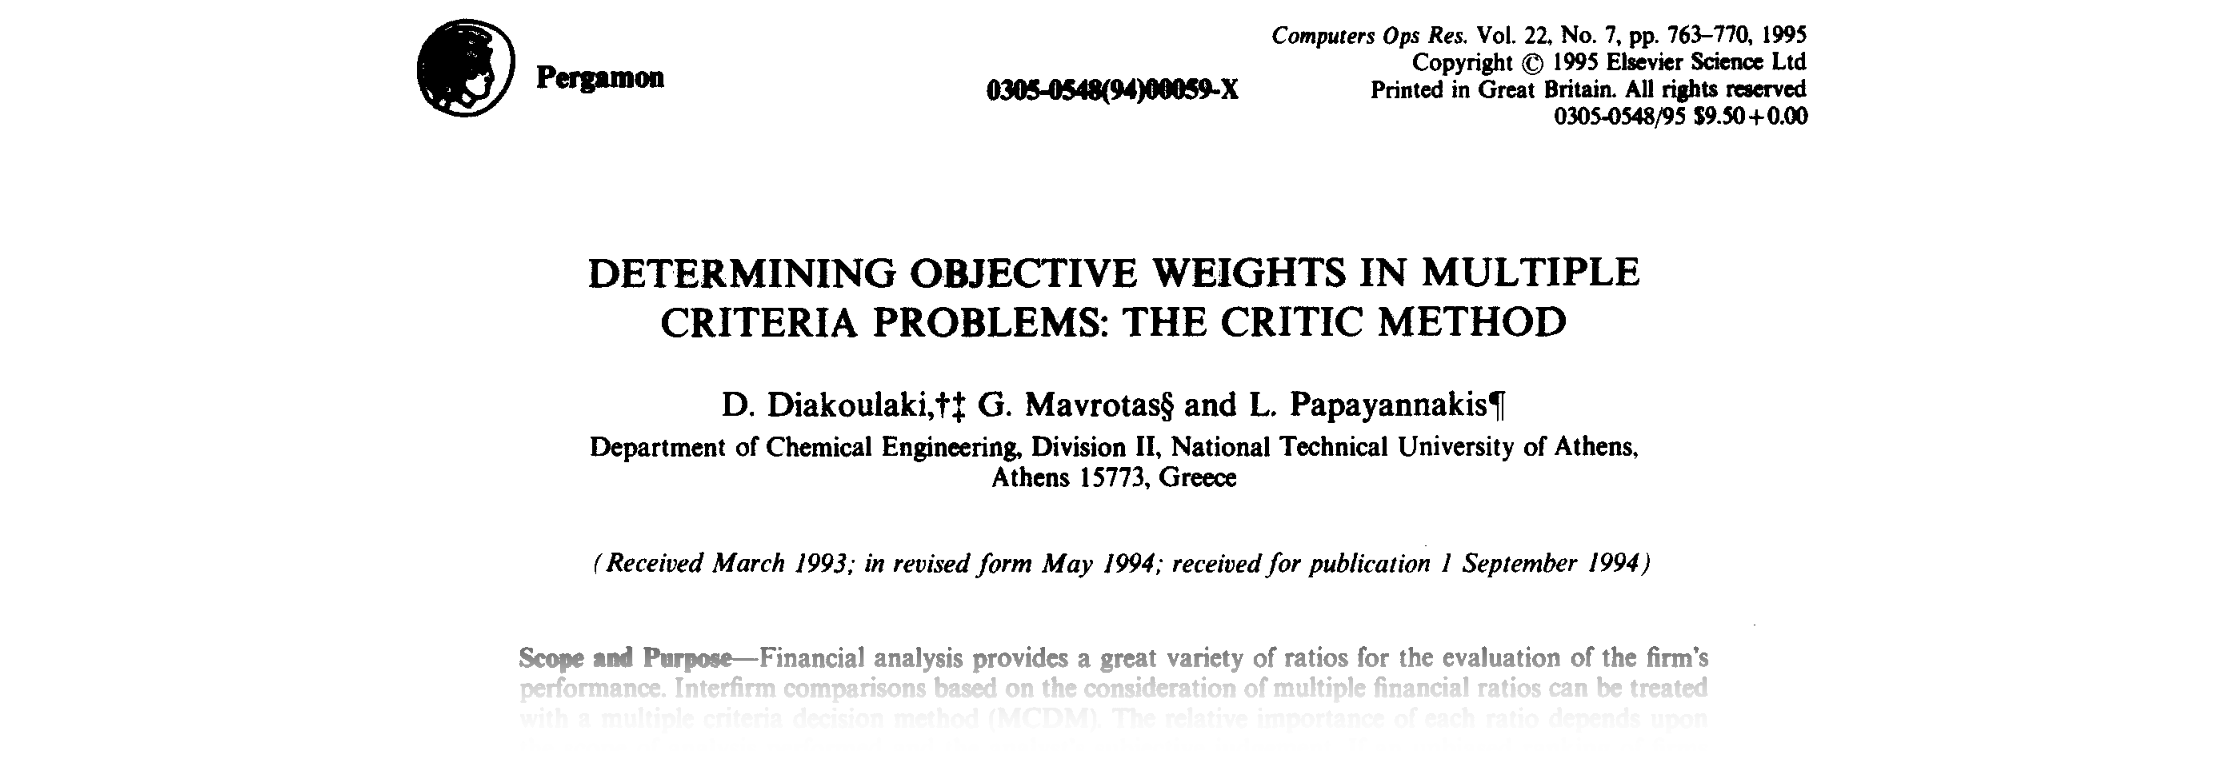

### CRITIC - El escalado sugerido: Distancias a un punto ideal

- El escalado mapea cada alternativa a un intervalo [0, 1] basado en el concepto de *punto ideal*.
- Asi el valor obtenido expresa que en que grado una alterntiva $a$ esta cerca de una alternativa ideal $a^+$  y que tan lejos esta de una alternativa anti-ideal $a^-$.
    - $a^+$ es una alternativa sintética formada por los valores máximos en los criterios a maximizar, y minimos en los a minimizar.
    - $a^-$ es una alternativa sintética formada por los valores máximos en los criterios a minimizar, y maximos en los a minimizar.
- Finalmente la matriz transformada esta dada por:

$$
r_{ij} = \frac{a_{ij} -  a^+}{a^+ - a^-}
$$

### CRITIC - El escalado sugerido: $a^+$ y $a^-$

Siendo nuestra matríz 

In [11]:
mtx = dm.matrix; objs = dm.objectives.to_numpy(); display(mtx), display(objs);

Criteria      ROE  CAP  RI
Alternatives              
PE              7    5  35
JN              5    4  26
AA              5    6  28
FX              3    4  36
MM              1    7  30
GN              5    8  30

array([<Objective.MAX: 1>, <Objective.MAX: 1>, <Objective.MIN: -1>],
      dtype=object)

Podemos calcular $a^+$ y $a^-$

In [12]:
import numpy as np
print("a⁺", np.where(objs == skc.Objective.MAX, mtx.max(), mtx.min()))
print("a-", np.where(objs == skc.Objective.MAX, mtx.min(), mtx.max()))

a⁺ [ 7  8 26]
a- [ 1  4 36]


### CRITIC - El escalado sugerido: `scalers.CenitDistanceMatrixScaler`

CRITIC usa esto internamente.

In [13]:
from skcriteria.preprocessing import scalers

skl = scalers.CenitDistanceMatrixScaler(); skl

<CenitDistanceMatrixScaler []>

In [14]:
skl.transform(dm)

ROE[▲ 1.0]  CAP[▲ 1.0]  RI[▼ 1.0]
PE    1.000000        0.25        0.1
JN    0.666667        0.00        1.0
AA    0.666667        0.50        0.8
FX    0.333333        0.00       -0.0
MM    0.000000        0.75        0.6
GN    0.666667        1.00        0.6
[6 Alternatives x 3 Criteria]

## CRITIC


$$
    C_j = \hat{s_j} \sum_{k=1}^n (1 - \hat{\rho}_{jk})
$$

donde:

- $C_j$ es la ponderación del criterio $j$.
- $\hat{s_j}$ es el desvío estandar del criterio $j$.
- $n$ es el número de criterios.
- $\hat{\rho}_{jk}$ es el coeficiente de correlación de *Pearson*/*Kendall*/*Spearman* entre los criterios $j$ y $k$. 

Finalmente los pesos se calculan como:

$$ w_j = \frac{C_j}{\sum_{k=1}^{n} C_k}$$

## CRITIC


$$
    C_j = \hat{s_j} \sum_{k=1}^n (1 - \hat{\rho}_{jk})
$$

O traducido:

> Los criterios mas importantes son los mas dispersos y menos correlacionados con los demas. 

Finalmente los pesos se calculan como:

$$ w_j = \frac{C_j}{\sum_{k=1}^{n} C_k}$$

## CRITIC

In [15]:
wght = weighters.CRITIC(); wght

<CRITIC [correlation='pearson', scale=True]>

In [16]:
wght.transform(dm)

/home/juanbc/proyectos/diplodatos_mcda/lib/python3.10/site-packages/skcriteria/preprocessing/weighters.py:405: UserWarning: Although CRITIC can operate with minimization objectives, this is not recommended. Consider reversing the weights for these cases.
  warnings.warn(


ROE[▲ 0.337001]  CAP[▲ 0.352684]  RI[▼ 0.310315]
PE                7                5              35
JN                5                4              26
AA                5                6              28
FX                3                4              36
MM                1                7              30
GN                5                8              30
[6 Alternatives x 3 Criteria]



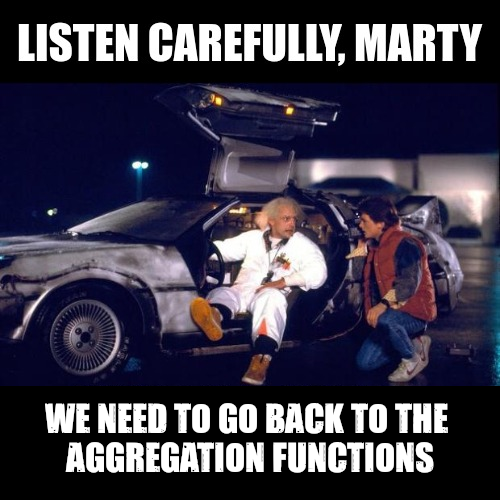


## Recarguemos los datos



In [17]:
dm = skc.datasets.load_simple_stock_selection()
dm

ROE[▲ 2.0]  CAP[▲ 4.0]  RI[▼ 1.0]
PE           7           5         35
JN           5           4         26
AA           5           6         28
FX           3           4         36
MM           1           7         30
GN           5           8         30
[6 Alternatives x 3 Criteria]

## Interludio

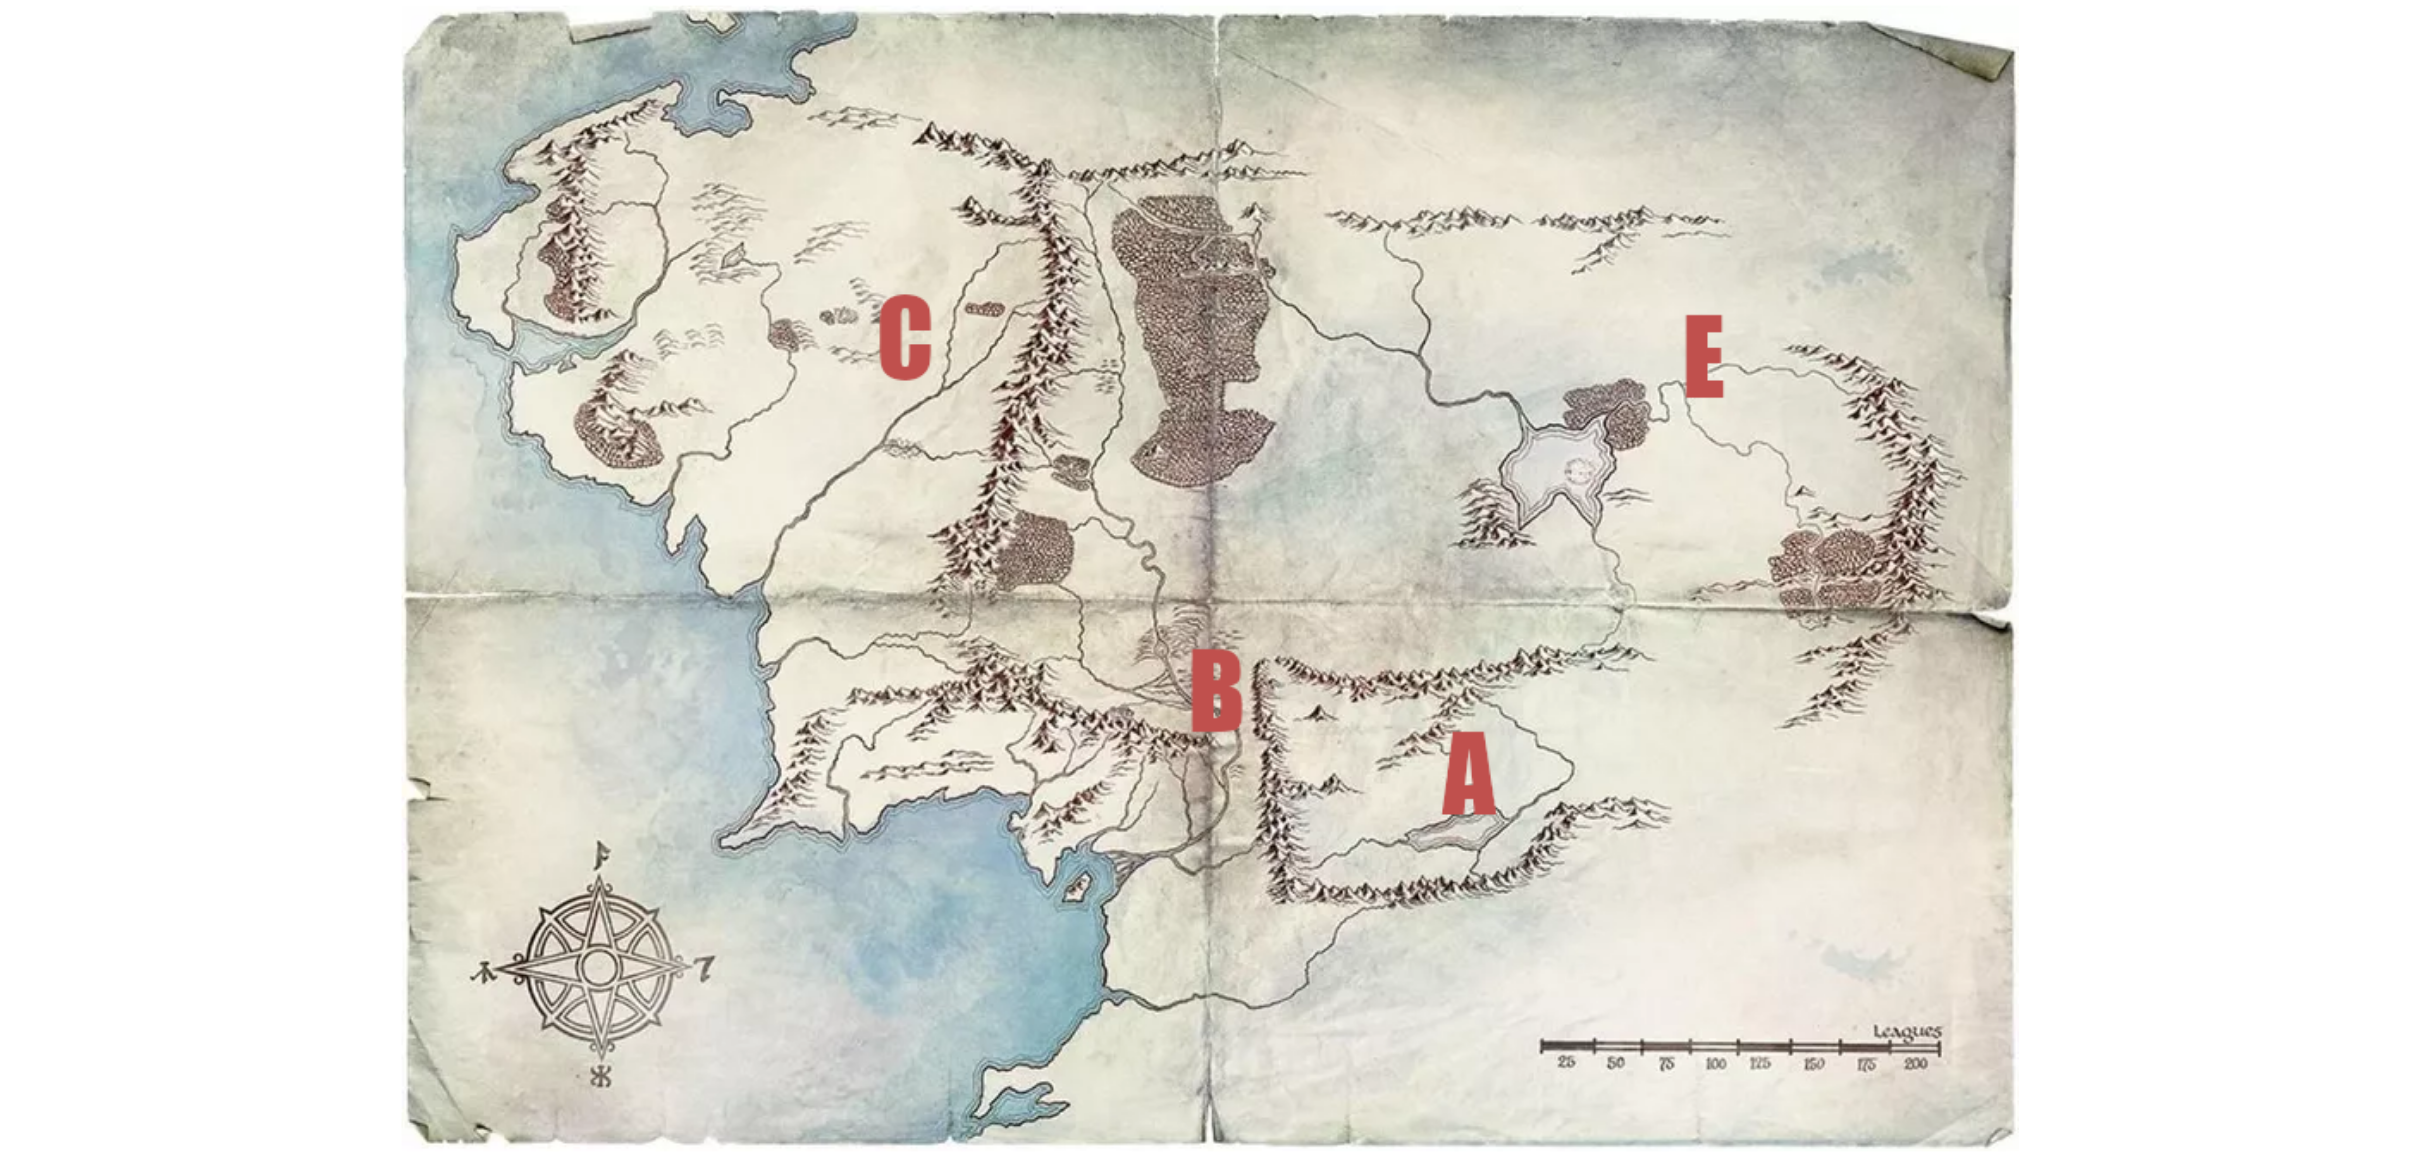

## Technique for Order Preference by Similarity to Ideal Solution (TOPSIS)

- Se basa en el concepto de que es deseable que una alternativa determinada se ubique a la distancia más corta respecto de una solución *ideal* y a la mayor distancia respecto a una solución *anti-ideal*.
- El procedimiento consta de una serie de pasos que permiten calcular un proporción llamado “*ratio de similaridad*” que valora el desempeño de cada alternativa.
- Es compensatorio.
- Se sugiere normalizar con el módulo del vector.
- Muy intuitivo y transparente.
- Si bien acepta múltiples medidas de distancia suele utilizarse la euclídea.
- Tolera los criterios de minimización.

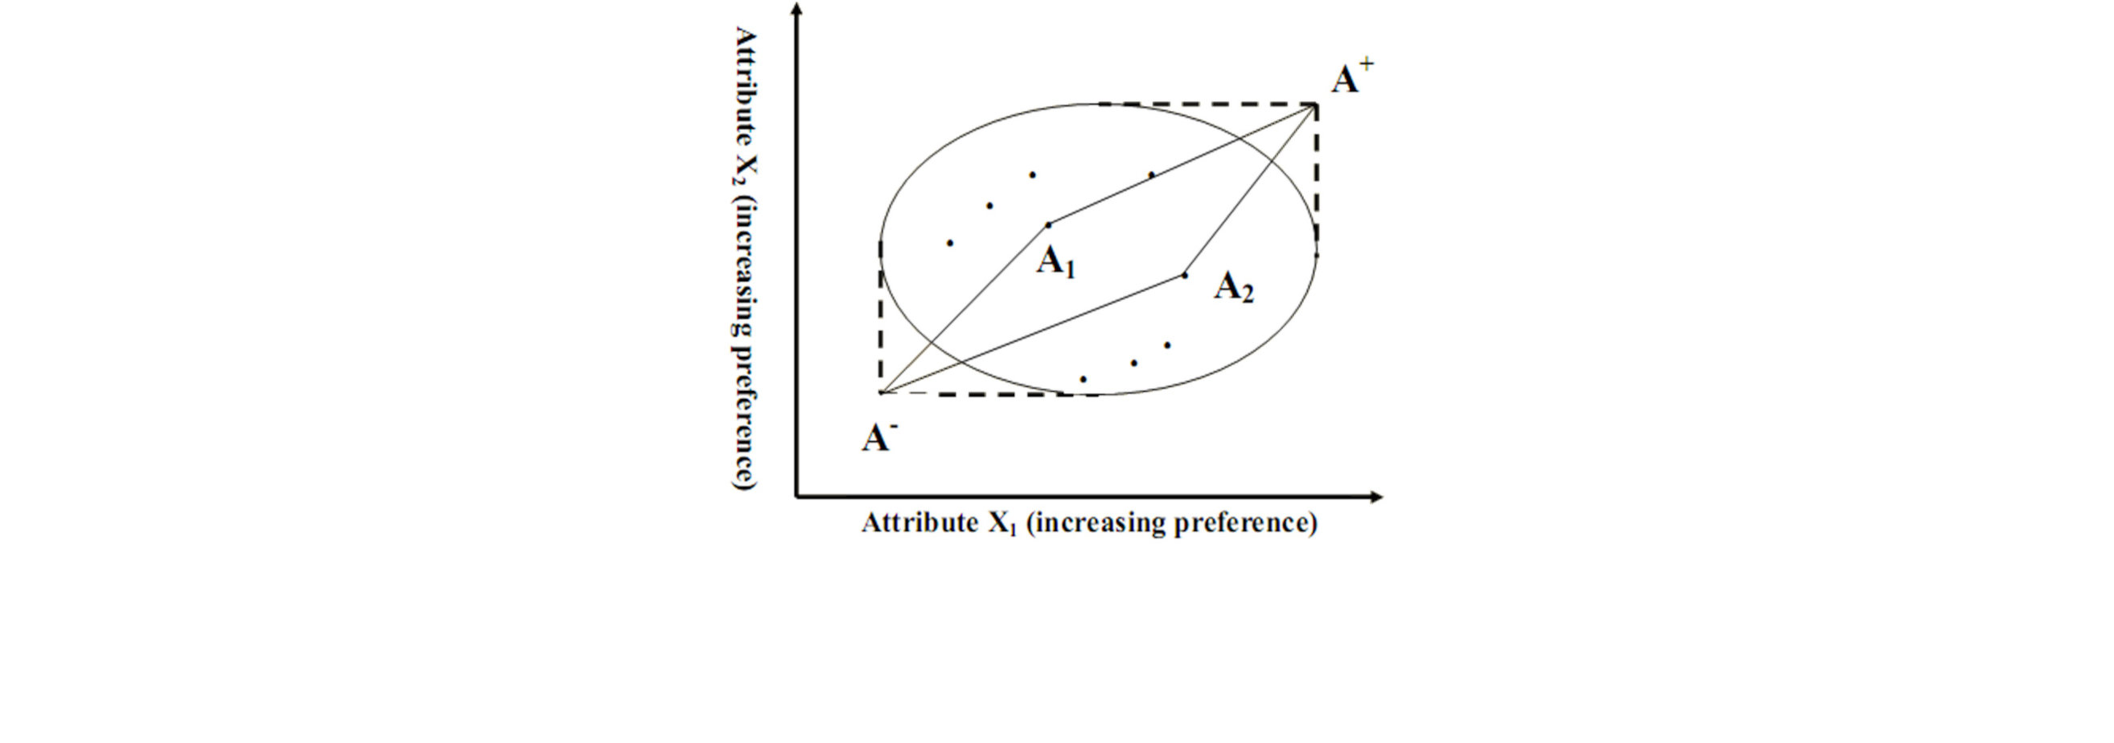

##  TOPSIS - Math

El índice de similaridad se define como

$$C_i = \frac{S_i^⁻}{S_i^+ + S_i^⁻}$$

Donde

- $C_i$ es el índice de similaridad.
- $S_i^+$ es la distancia de la alternativa $i$ respecto al valor *ideal*.
- $S_i^⁻$ es la distancia de la alternativa $i$ respecto al valor *anti-ideal*.

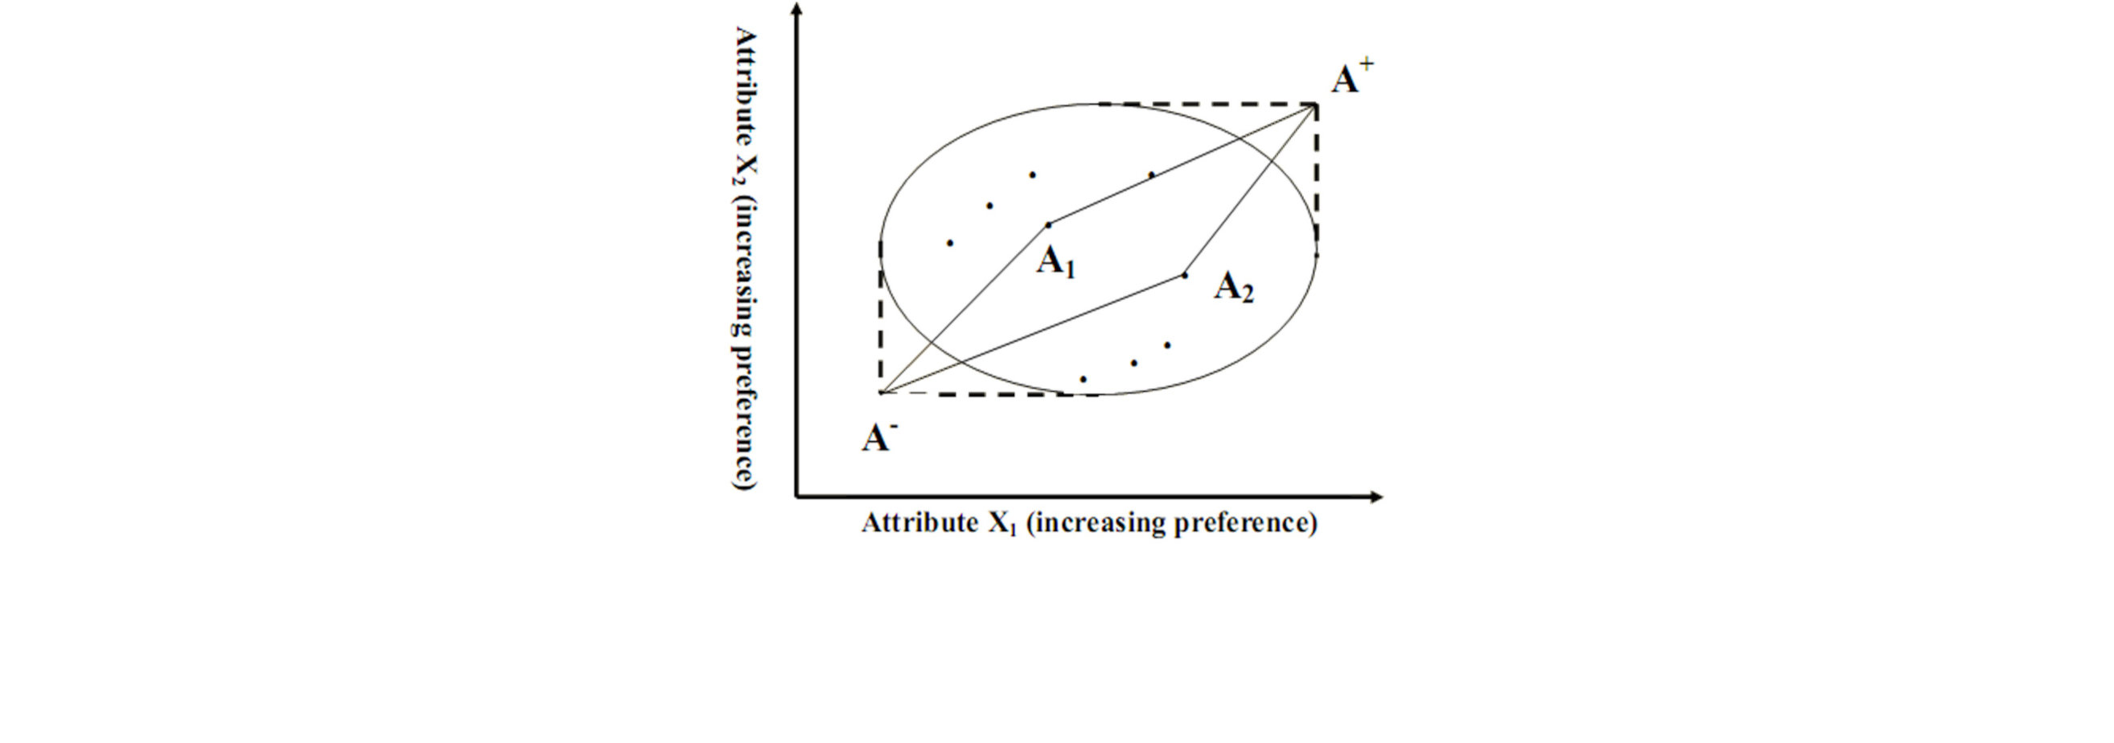

## TOPSIS - Mucho Ojo - Sobre como eliminar metodos a minimizar.

**Sí o Sí** se usa `NegateMinimizer`, o destruyen la relación de distancias!

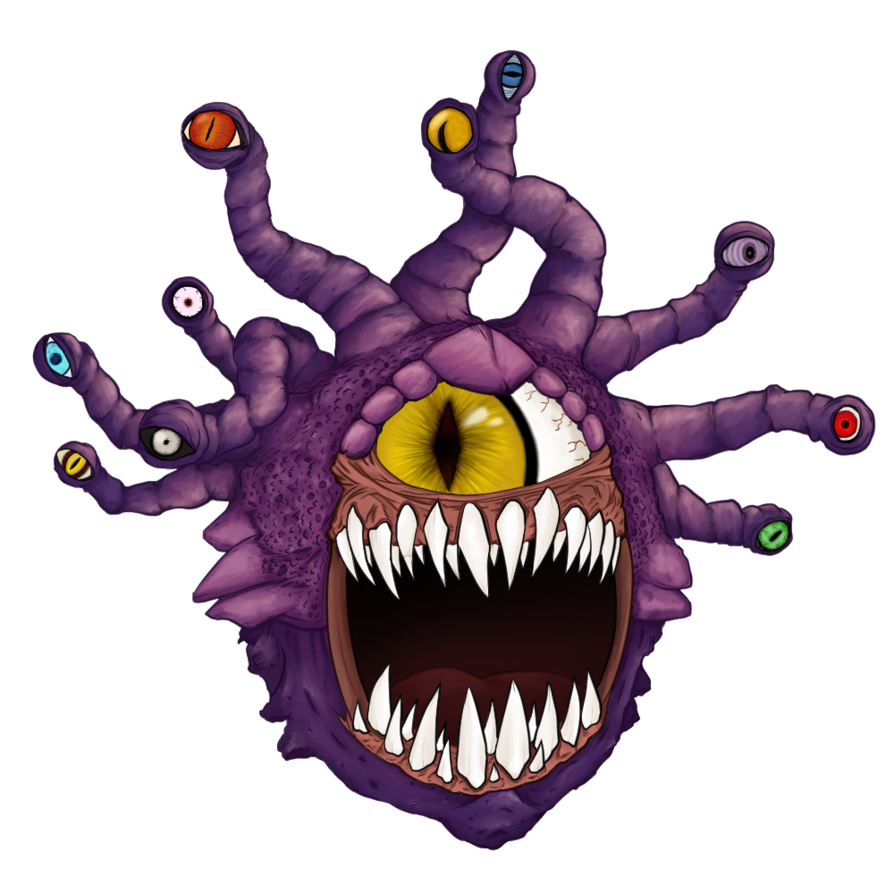

## `skriteria.madm.similarity.TOPSIS`

In [18]:
from skcriteria.preprocessing.invert_objectives import NegateMinimize  # SI O SI
from skcriteria.preprocessing.scalers import VectorScaler, SumScaler
from skcriteria.preprocessing.filters import FilterGE, FilterNonDominated
from skcriteria.pipeline import mkpipe
from skcriteria.madm.similarity import TOPSIS 

In [19]:
tp_pipe = mkpipe(
    NegateMinimize(), 
    FilterGE({"ROE": 2}, ignore_missing_criteria=True), FilterNonDominated(),
    SumScaler(target="weights"), VectorScaler(target="matrix"),
    TOPSIS()
)
tp_pipe

<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('filterge', <FilterGE [criteria_filters={'ROE': 2}, ignore_missing_criteria=True]>), ('filternondominated', <FilterNonDominated [strict=False]>), ('sumscaler', <SumScaler [target='weights']>), ('vectorscaler', <VectorScaler [target='matrix']>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

## `skriteria.madm.similarity.TOPSIS`

In [20]:
result = tp_pipe.evaluate(dm)
result

Alternatives  PE  JN  AA  GN
Rank           3   4   2   1
[Method: TOPSIS]

In [21]:
result.e_.ideal, result.e_.anti_ideal

(array([ 0.1796053 ,  0.38498374, -0.06203413]),
 array([ 0.1282895 ,  0.19249187, -0.08350749]))

## ÉLimination et Choix Traduisant la REalité (ELECTRE)
- Es una familia de métodos de la "escuela francesa".
- Son métodos no compensarios.
- Diseñan internamente indices de superación entre las alternativas.
- En particular ELECTRE1, no resuelve un ranking sino un kernel.
- Determina que la relación de superación $S$ entre dos alternativas se
  establece mediante:
  - El umbral de concordancia $p^*$, que determina hasta qué punto dado los criterios una alternativa es preferida a otra
  - El umbral de discordancia $q^*$: que mide hasta qué punto no existe ningún criterio para el que una alternativa es mucho mejor que otra.
- Para comparar el desempeño de cada alternativa se deben calcular los índices de *concordancia* y *discordancia*


## ELECTRE-I: Índice de concordancia

Mide en qué grado la alternativa $a$ es al menos tan buena como la $b$.

$$
    C_{(a,b)} = \frac{\sum_{j:g_j(a) \ge g_j(b)} w_j}{\sum_{j=1}^J w_j}
$$

Donde:

- $w_j$ es el peso del criterio $j$.
- $J$ es el conjunto de índices del criterio $j$.
- $g_j(a)$ es la valoración de la alternativa $a$ para el criterio $j$.
- $g_j(b)$ es la valoración de la alternativa $b$ para el criterio $j$.


## ELECTRE-I: Índice de discordancia

Mide el grado en que $a$ no se prefiere sobre $b$

$$
    D_(a,b) = \max_{\{j:g_j(a) < g_j(b)\}} \bigg\{ \frac{g_j(b) - g_j(a)}{\delta} \bigg\}
$$

Donde:

- $g_j(a)$, es la valoración de la alternativa $a$ para el criterio $j$.
- $g_j(b)$, es la valoración de la alternativa $b$ para el criterio $j$.
- $\delta = \max_{j}  |g_j(b) - g_j(a)|$, es la máxima diferencia en cualquier criterio.

## Combinando $C_{(a,b)}$ y $D_{(a, b)}$ con los umbrales

- $p^*$, es el umbral de concordancia.
- $q^*$, es el umbral de discordancia.
- $C_{(a,b)}$, mide en qué grado la alternativa $a$ es al menos tan buena como la $b$.
- $D_{(a, b)}$, mide el grado en que $a$ no se prefiere sobre $b$

Entonces:

Si $C_{(a,b)} \ge p^*$ y $D_{(a,b)} \le q^*$ entonces $a \succ b$.


**O en cristiano:**
    
Si $a$ se prefiere sobre $b$ con un nivel $p^*$ y además no es peor dado un umbral $q^*$, entonces $a$ domina a $b$

## `skriteria.madm.electre.ELECTRE1`

In [22]:
from skcriteria.preprocessing.invert_objectives import InvertMinimize
from skcriteria.madm.electre import ELECTRE1

e1_pipe = mkpipe(
    InvertMinimize(),
    FilterGE({"ROE": 2}, ignore_missing_criteria=True), FilterNonDominated(),
    SumScaler(target="weights"), VectorScaler(target="matrix"), 
    ELECTRE1()
)
e1_pipe

<SKCPipeline [steps=[('invertminimize', <InvertMinimize []>), ('filterge', <FilterGE [criteria_filters={'ROE': 2}, ignore_missing_criteria=True]>), ('filternondominated', <FilterNonDominated [strict=False]>), ('sumscaler', <SumScaler [target='weights']>), ('vectorscaler', <VectorScaler [target='matrix']>), ('electre1', <ELECTRE1 [p=0.65, q=0.35]>)]]>

In [23]:
result = e1_pipe.evaluate(dm)
result

Alternatives    PE     JN     AA    GN
Kernel        True  False  False  True
[Method: ELECTRE1]

## `KernelResult`

Algunos métodos útiles

In [24]:
result.kernel_  # máscara del kernel

array([ True, False, False,  True])

In [25]:
result.kernel_alternatives_  # que alternativas estan en el kernel

array(['PE', 'GN'], dtype=object)

In [26]:
result.kernel_where_  # índices del kernel

array([0, 3])

In [27]:
result.to_series()  # convertir el kernel a una pandas.Series

Alternatives
PE     True
JN    False
AA    False
GN     True
Name: Kernel, dtype: bool

## Volviendo a `ELECTRE1`

Se pueden explorar las matrices intermedias de cálculo.

In [28]:
result.e_

<extra {'matrix_discordance', 'matrix_concordance', 'outrank'}>

In [29]:
result.e_.matrix_discordance # >= pipe[-1].p

array([[       nan, 0.42906585, 0.30988089, 0.75      ],
       [0.5331737 ,        nan, 0.5       , 1.        ],
       [0.5331737 , 0.11918496,        nan, 0.5       ],
       [0.5331737 , 0.22247859, 0.10329363,        nan]])

In [30]:
result.e_.matrix_discordance # <= pipe[-1].q

array([[       nan, 0.42906585, 0.30988089, 0.75      ],
       [0.5331737 ,        nan, 0.5       , 1.        ],
       [0.5331737 , 0.11918496,        nan, 0.5       ],
       [0.5331737 , 0.22247859, 0.10329363,        nan]])

## Interpretación de la matríz de outrank

- La alternativa fila domina la alternativa columna si el valor es `True`.
- Osea el kernel esta en la alternativa que no tiene `True` en las columnas (Alternativas no dominadas)

In [31]:
result.e_.outrank

array([[False, False, False, False],
       [False, False, False, False],
       [False,  True, False, False],
       [False,  True,  True, False]])

Pero esto se puede ver como grafos!

## Interpretación de la matríz de outrank

No esta dominado todo lo que **no** le entran flechas

Esto no esta implementado en `skcriteria` y recurrimos a [NetworkX](https://networkx.org/)

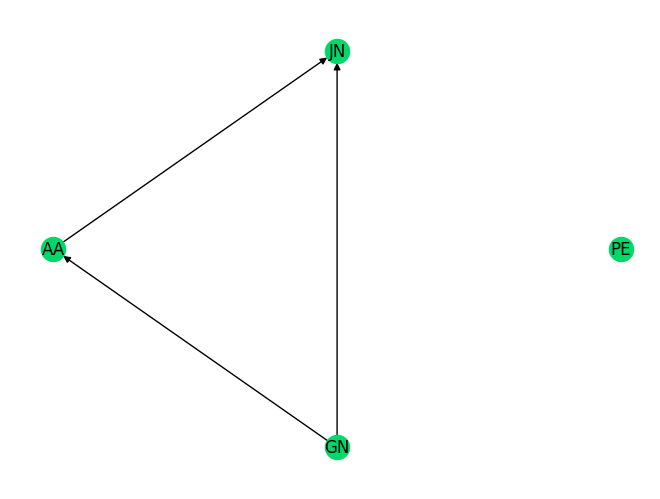

In [61]:
import networkx as nx
import pandas as pd
df = pd.DataFrame(result.e_.outrank, columns=result.alternatives, index=result.alternatives)
dg = nx.from_pandas_adjacency(df, nx.DiGraph); nx.draw_circular(dg, node_color='#00d969', with_labels=True);

## Interludio

- En este punto es interesante notar que ya vimos 4 funciones de agregación distintas.
- Las cosas que hacen son bastante diferentes, y aun hay muchas más.
- Entonces surge la pregunta de:

> Cual es el mejor MCDM?

## Interludio

Qué podemos elegir en un método multi-criterio?

- Sea fácil de entender?
- Representación del problema coherente?
- Que al mínimo cambio de pesos no te cambie todo bruscamente?
- Que cualquier nueva alternativa que metas no te distorsione demasiado el ranking?

No se si se entiende lo que esta pasando?

### La paradoja de los métodos multicriterio

> Elegir el mejor método multicriterio, es un problema multicriterio.

- En realidad afecta a toda la toma de decisiones.
- Fuente original.

> Triantaphyllou, E., & Mann, S. H. (1989). An examination of the effectiveness of multi-dimensional decision-making methods: A decision-making paradox. Decision Support Systems, 5(3), 303-312.

- Me recuerda al "[No free lunch theorem](https://machinelearningmastery.com/no-free-lunch-theorem-for-machine-learning/)", que dicho sea de paso tambien nos afecta.


## La paradoja de los métodos multicriterio

Todo muy lindo pero que hacemos?

- Herramientas para comparar rankings a lo cavernicola.
- Aprovechar el concepto de reversión de rankings.
- Análisis de sensibilidad.

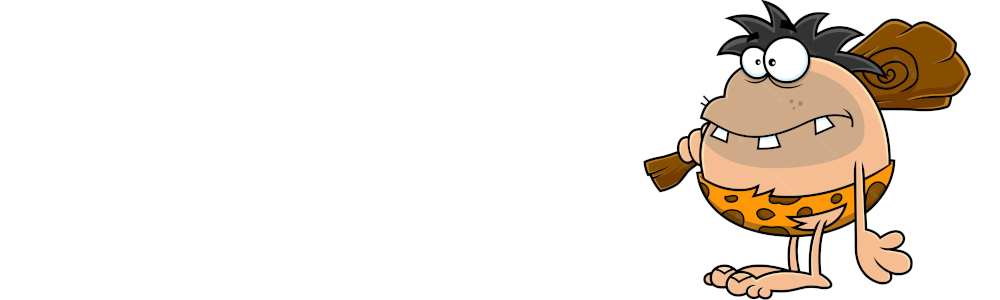

## Herramientas para comparar rankings a lo cavernicola.

A partir de *Scikit-Criteria* 0.8 (la que liberé para este curso) existe una clase que se llama `cmp.RanksComparator`, que consume múltiples resultados y provee unas cuántas herramientas de análisis de correlación, regresión y comparación directa de rankings.

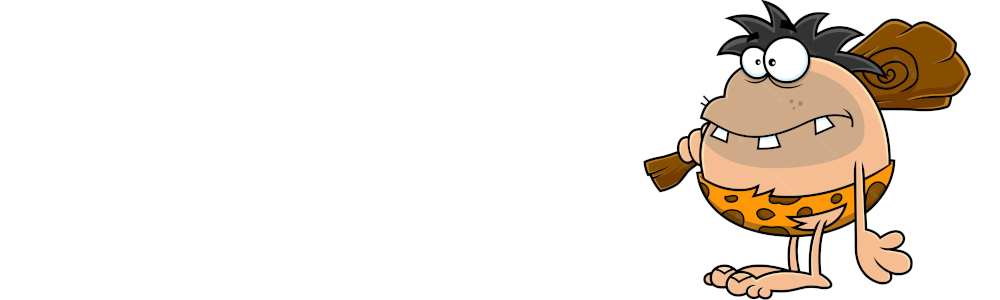

In [33]:
from skcriteria.cmp import RanksComparator, mkrank_cmp

## Más ejemplos para que esto sea un cachito mas interesante.

Importemos un dataset mas interesante

In [34]:
dm = skc.datasets.load_van2021evaluation(windows_size=7)
dm

xRV[▲ 1.0]  sRV[▼ 1.0]    xVV[▲ 1.0]    sVV[▼ 1.0]  xR2[▲ 1.0]  \
ADA        0.029       0.156  8.144000e+09  1.586000e+10       0.312   
BNB        0.033       0.167  6.141000e+09  1.118000e+10       0.396   
BTC        0.015       0.097  2.095000e+11  1.388000e+11       0.281   
DOGE       0.057       0.399  8.287000e+09  2.726000e+10       0.327   
ETH        0.023       0.127  1.000000e+11  8.054000e+10       0.313   
LINK       0.040       0.179  6.707000e+09  1.665000e+10       0.319   
LTC        0.015       0.134  2.513000e+10  1.731000e+10       0.320   
XLM        0.013       0.176  4.157000e+09  5.469000e+09       0.321   
XRP        0.014       0.164  2.308000e+10  2.924000e+10       0.322   

         xm[▲ 1.0]  
ADA   1.821000e-11  
BNB   9.167000e-09  
BTC   1.254000e-08  
DOGE  1.459000e-12  
ETH   1.737000e-09  
LINK  1.582000e-09  
LTC   1.816000e-09  
XLM   1.876000e-11  
XRP   7.996000e-12  
[9 Alternatives x 6 Criteria]

## Mas ejemplos para que esto sea un cachito mas interesante.

In [35]:
from skcriteria.madm.simple import WeightedProductModel, WeightedSumModel
ws_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"), VectorScaler(target="matrix"), 
    WeightedSumModel()
)

wp_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"), VectorScaler(target="matrix"), 
    WeightedProductModel()
)

wsum_result = ws_pipe.evaluate(dm)
wprod_result = wp_pipe.evaluate(dm)
tp_result = tp_pipe.evaluate(dm)

display(wsum_result, wprod_result, tp_result)

Alternatives  ADA  BNB  BTC  DOGE  ETH  LINK  LTC  XLM  XRP
Rank            8    2    1     7    3     5    6    4    9
[Method: WeightedSumModel]

Alternatives  ADA  BNB  BTC  DOGE  ETH  LINK  LTC  XLM  XRP
Rank            6    2    1     9    3     5    4    7    8
[Method: WeightedProductModel]

Alternatives  ADA  BNB  BTC  DOGE  ETH  LINK  LTC  XLM  XRP
Rank            6    2    1     8    5     3    4    7    9
[Method: TOPSIS]

## Creamos el `RanksComparator`

Hay dos formas crear los ranks comparators:

1. O usamos la clase dando un secuencia `[("nombre", rank), ...]`

In [36]:
RanksComparator([("ts", tp_result), ("ws", wsum_result), ("wp", wprod_result)])

<RanksComparator [ranks=['ts', 'ws', 'wp']]>

O dejamos que los nombres se infieran de los métodos con la función `mkrank_cmp`

In [37]:
rcmp = mkrank_cmp(tp_result, wsum_result, wprod_result)
rcmp

<RanksComparator [ranks=['TOPSIS', 'WeightedSumModel', 'WeightedProductModel']]>

##  Utilidades implementadas en los `RankComparator`

Se ofrecen un conjuntos de estadisticos útiles al momento de comparar correlaciones, tendencias y covarianzas entre los diferents rankings

Podemos empezar viendo las correlaciones

In [38]:
rcmp.corr()

Method                  TOPSIS  WeightedSumModel  WeightedProductModel
Method                                                                
TOPSIS                1.000000          0.783333              0.916667
WeightedSumModel      0.783333          1.000000              0.816667
WeightedProductModel  0.916667          0.816667              1.000000

In [39]:
rcmp.corr(method="kendall")

Method                  TOPSIS  WeightedSumModel  WeightedProductModel
Method                                                                
TOPSIS                1.000000          0.666667              0.777778
WeightedSumModel      0.666667          1.000000              0.666667
WeightedProductModel  0.777778          0.666667              1.000000

##  Utilidades implementadas en los `RankComparator`

Se ofrecen un conjuntos de estadisticos útiles al momento de comparar correlaciones, tendencias y covarianzas entre los diferents rankings

Tambíen estan disponibles las covarianzas

In [40]:
rcmp.cov()

Method                TOPSIS  WeightedSumModel  WeightedProductModel
Method                                                              
TOPSIS                 7.500             5.875                 6.875
WeightedSumModel       5.875             7.500                 6.125
WeightedProductModel   6.875             6.125                 7.500

Y el $R^2$ score (el mismo de la regresión lineal) entre rankings

##  Utilidades implementadas en los `RankComparator`

Se ofrecen un conjuntos de estadísticos útiles al momento de comparar correlaciones, tendencias y covarianzas entre los diferents rankings

Otra cosa disponible es es analizar que tan distantes esta un ranking del otro.

Por defecto se utiliza la [distancia de Hamming](https://en.wikipedia.org/wiki/Hamming_distance), pero puede utilizarse cualquiera de las disponibles para la función [`scipy.spatial.distance.pdist()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)

In [41]:
rcmp.distance()

Method                  TOPSIS  WeightedSumModel  WeightedProductModel
Method                                                                
TOPSIS                0.000000          0.666667              0.444444
WeightedSumModel      0.666667          0.000000              0.555556
WeightedProductModel  0.444444          0.555556              0.000000

In [42]:
rcmp.distance(metric="cityblock")

Method                TOPSIS  WeightedSumModel  WeightedProductModel
Method                                                              
TOPSIS                   0.0              12.0                   6.0
WeightedSumModel        12.0               0.0                  10.0
WeightedProductModel     6.0              10.0                   0.0

##  Utilidades implementadas en los `RankComparator`

Se ofrecen un conjuntos de estadísticos útiles al momento de comparar correlaciones, tendencias y covarianzas entre los diferents rankings

Tambien puede proveerse una función de distancia

In [43]:
def my_distance(u,v,w=None):
    return 42

rcmp.distance(metric=my_distance)

Method                TOPSIS  WeightedSumModel  WeightedProductModel
Method                                                              
TOPSIS                   0.0              42.0                  42.0
WeightedSumModel        42.0               0.0                  42.0
WeightedProductModel    42.0              42.0                   0.0

##  Utilidades implementadas en los `RankComparator`

Finalmente, si todo esto es insuficiente, podemos convertir el comparador en un dataframe

In [44]:
rcmp.to_dataframe()

Method        TOPSIS  WeightedSumModel  WeightedProductModel
Alternatives                                                
ADA                6                 8                     6
BNB                2                 2                     2
BTC                1                 1                     1
DOGE               8                 7                     9
ETH                5                 3                     3
LINK               3                 5                     5
LTC                4                 6                     4
XLM                7                 4                     7
XRP                9                 9                     8

##  Utilidades implementadas en los `RankComparator` - Plots!

El otro juego de herramientas de analisis son las visualización.

Un clásico es el *Ranking flows*

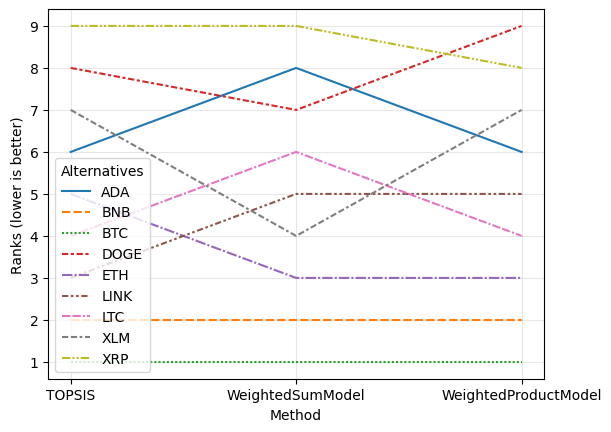

In [45]:
rcmp.plot.flow();  # untied, y mostra un ejemplo juancito!

##  Utilidades implementadas en los `RankComparator` - Plots!

También se pueden hacer regresiones sobre todas las combinaciones de diferentes rankings

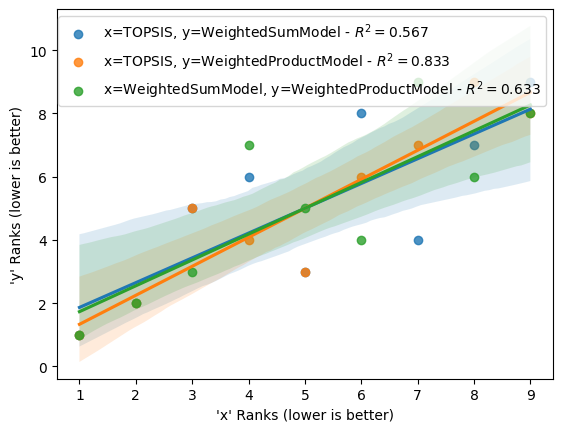

In [46]:
rcmp.plot.reg(r2=True, r2_fmt=".3f");

##  Utilidades implementadas en los `RankComparator` - Plots!

Hay gráficos de barras.

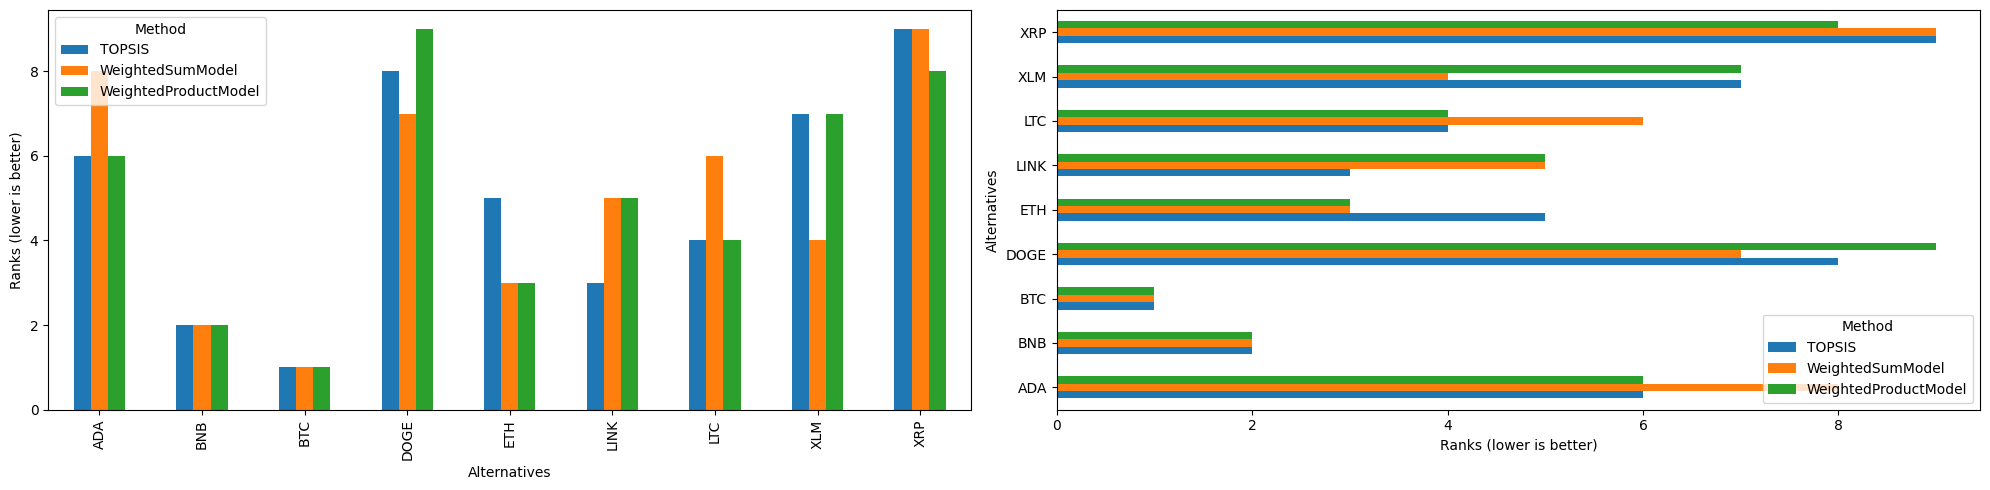

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

rcmp.plot.bar(ax=axs[0]) 
rcmp.plot.barh(ax=axs[1]) 

fig.tight_layout();

##  Utilidades implementadas en los `RankComparator` - Plots!

También hay boxplots

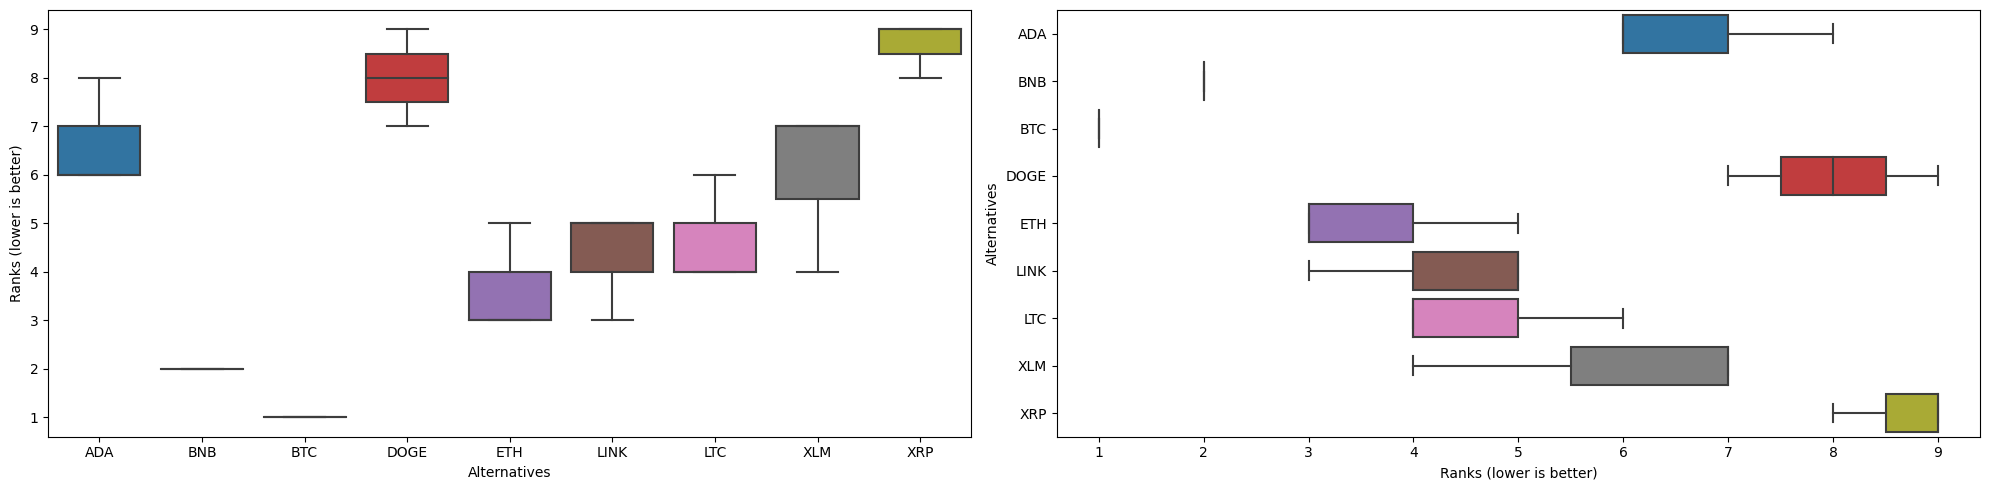

In [48]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

rcmp.plot.box(ax=axs[0]) 
rcmp.plot.box(ax=axs[1], orient="h") 

fig.tight_layout();

##  Utilidades implementadas en los `RankComparator` - Plots!

Y también se pueden hacer todas las matrices de análisis como heatmaps

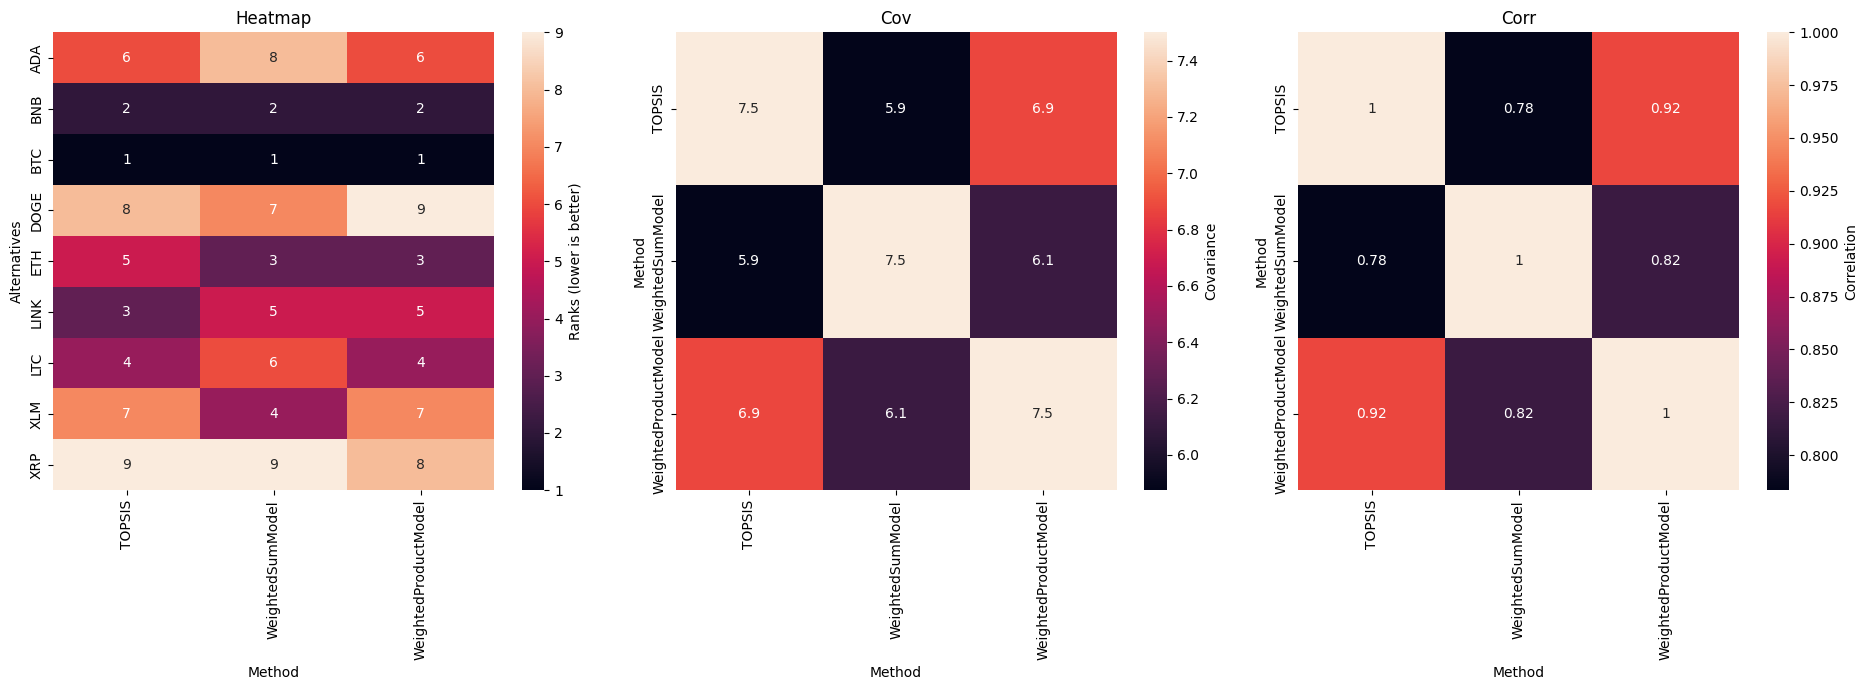

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(19, 7))

for kind, ax in zip(["heatmap", "cov", "corr"], axs):
    rcmp.plot(kind, ax=ax)
    ax.set_title(kind.title())


fig.tight_layout()

##  Utilidades implementadas en los `RankComparator` - Plots!

Y también se pueden hacer todas las matrices de análisis como heatmaps

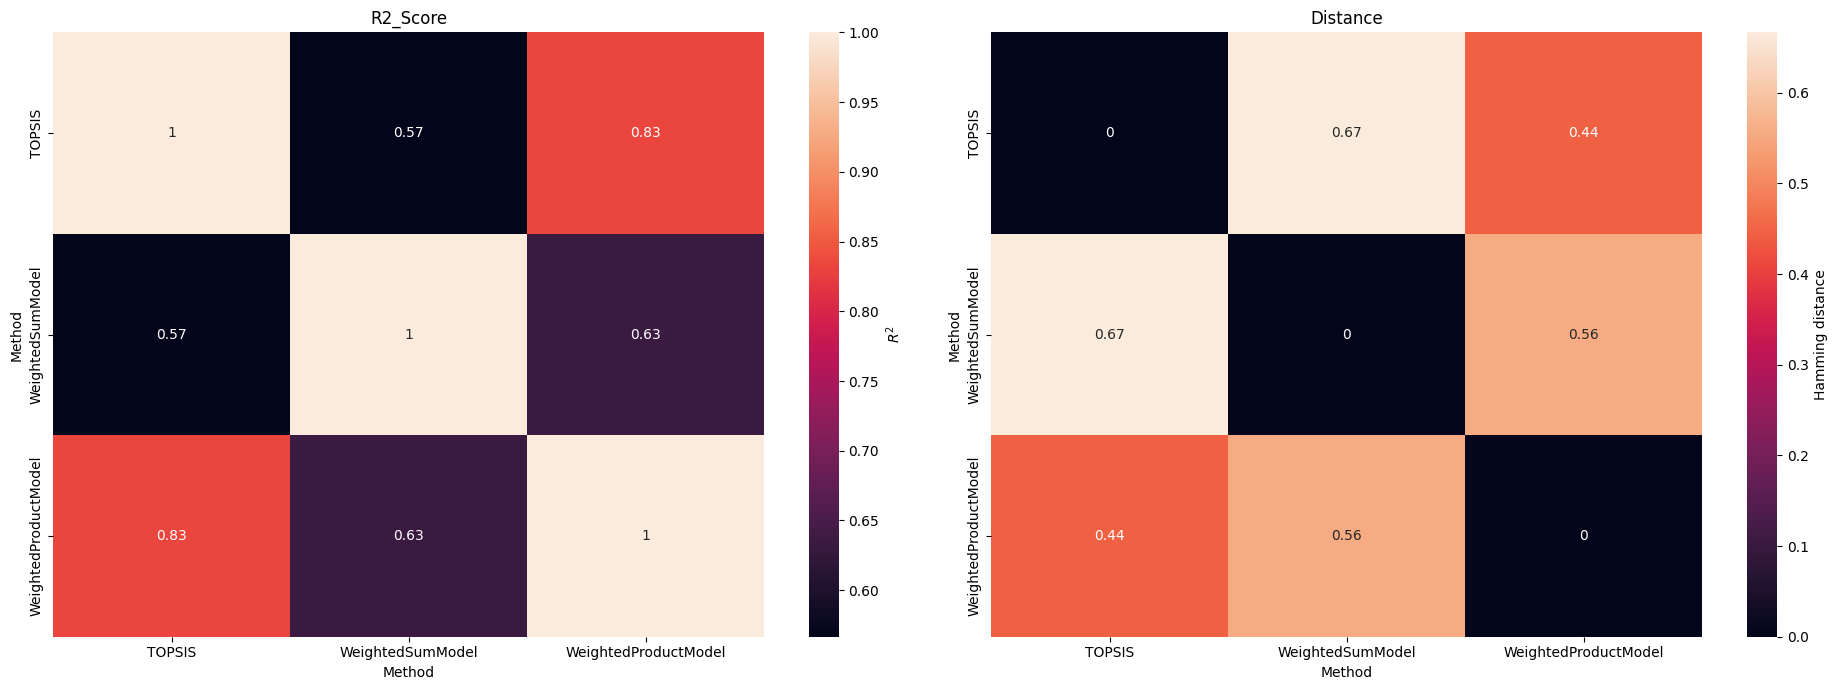

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))

for kind, ax in zip(["r2_score", "distance"], axs):
    rcmp.plot(kind, ax=ax)
    ax.set_title(kind.title())


fig.tight_layout()

## Reversión de rankings

Un problema interesante de los métodos de toma de decisiones es que, a menudo, diferentes métodos pueden dar respuestas diferentes cuando se alimentan con exactamente los mismos datos numéricos. Esto es llamado *Rank Reversal* o *Rank Irregularities*.

Así, se plantea naturalmente la cuestión de la evaluación del rendimiento relativo de esos métodos.

Esto, a su vez, plantea la cuestión de cómo se puede evaluar el rendimiento de dichos métodos.

La comunidad estableció tres criterios de prueba para comprobar el rendimiento relativo de varios métodos de MCDM.

**Vamos a ver en detalle solo el primero**





## Reversión de rankings

Un problema interesante de los métodos de toma de decisiones es que, diferentes métodos pueden dar respuestas diferentes cuando se alimentan con exactamente los mismos datos numéricos. Esto es llamado *Rank Reversal* o *Rank Irregularities*.

Se plantea naturalmente la cuestión de la evaluación del rendimiento relativo de esos métodos.

La comunidad estableció tres criterios de prueba para comprobar el rendimiento relativo de varios métodos de MCDM.

**Vamos a ver en detalle solo el primero**

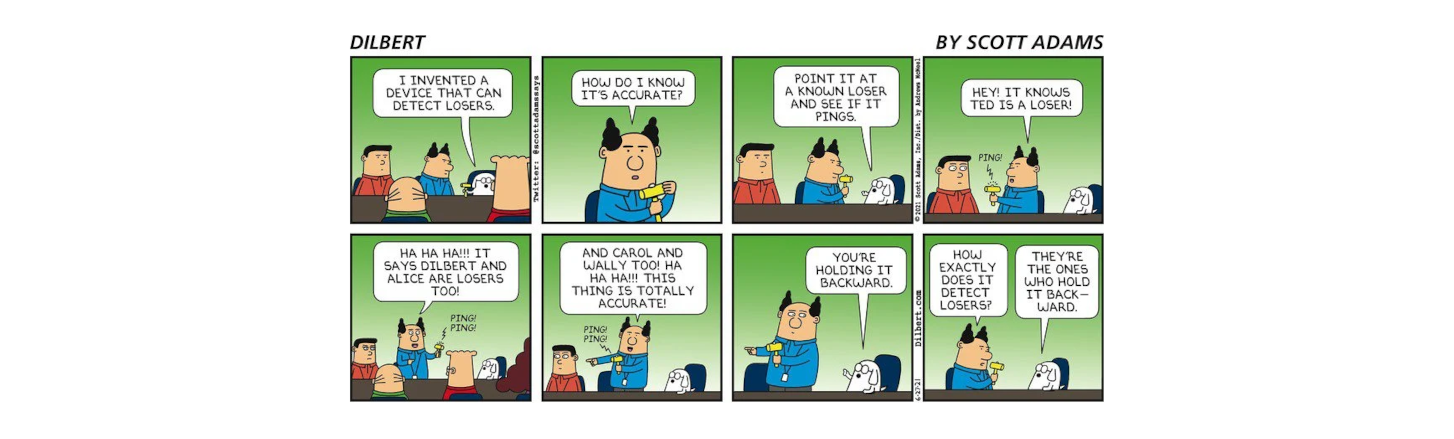



## Reversión de rankings - Test #1

Un método MCDM eficaz no debería cambiar la indicación de la **mejor alternativa** cuando una
alternativa **no óptima** es sustituida por otra alternativa **peor** (dado que la importancia relativa de cada criterio de decisión no cambia).

- Supongamos que un MCDM ha clasificado un conjunto de alternativas de alguna manera. 
- A continuación, supongamos que una alternativa no óptima $A_k$, es sustituida por otra alternativa, $A_k'$ que es menos deseable que $A_k$.
- La mejor alternativa no debería cambiar cuando se utilice el mismo MCDM.
- Lo mismo debería ocurrir con las clasificaciones relativas del resto de las alternativas que no cambian.

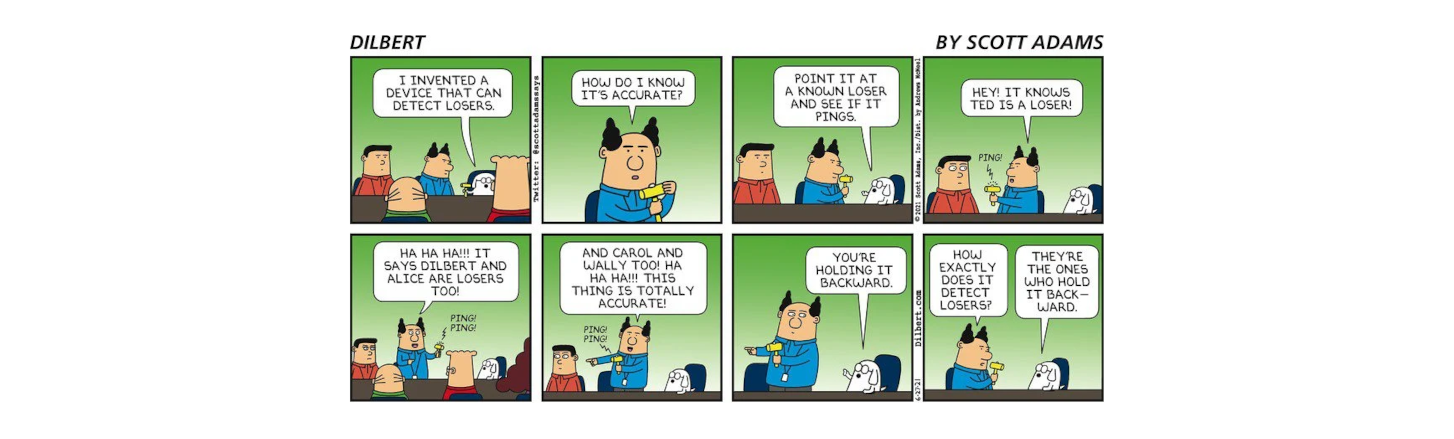



## Reversión de rankings - Test #1

Scikit-Criteria no ofrece directamente una herramienta para evaluar reversión de rankings, pero si se adjunta un prototipo que sera integrado a skcriteria v0.9.

El algoritmo tiene que hacer conseciones para funcionar numericamente.

### Hiper-Parametros

- `decision_maker`: El método o pipeline que se quiere evaluar
- `repeats=1`: Cuántas veces cambiar cada alternativa por una peor.
- `allow_missing_alternatives=False`: Permitir que algún cambio elimine una alternativa.
- `last_diff_strategy=np.nanmedian`: Cuáles son los límites de variación de la última alternativa en el ranking.
- `seed=None`: La semilla para generar las variaciones aleatorias.




## Reversión de rankings - Test #1

El algoritmo opera de la siguiente forma:

### 1. Cálculo del ranking de referencia y limites de variación

1. Comienza claculando el ranking *original* con la matríz de decisión provista.
2. Ordena las alternativas en la matriz de decision segun ese ranking y descarta la alternativa en el ranking 1.
3. Calcula las diferencias en valor absoluto criterio a criterio de una alternativa en el ranking $i$ con la del ranking $i+1$. Estos valores se utilizaran como valor máximo de variación cuando se reemplace la alternativa $i$ por una peor.
4. Como la última alternativa no tiene con quien compararse, se pone como valores máximos de variación los valores resultantes de aplicar `last_diff_strategy` a los valores calculados previamente. Se utiliza la media para evitar problemas de pocos valores y evitar outliers.


## Reversión de rankings - Test #1

El algoritmo opera de la siguiente forma:

### 3. Parte iterativa y retorno

5. Los siguientes pasos se repiten `repeats` veces:
    - *5.1-* Los siguientes pasos se repiten una vez por alernativa no optima $A_i$:
        - *5.1.1-* Se genera vector aletorio uniforme por criterio entre $[0, x)$, donde $x = |a_{i,j} - a_{i+1,j}|$ 
        - *5.1.2-* Se incrementa/decrementa cada valor de $A_i$ con los valores de ruido obtenidos en *5.1.1* creando así $A_i' / A_i \succ A_i'$.
        - *5.1.3-* Se vuelve a ejecutar el decisor con esta matrix y crea un nuevo ranking
        - *5.1.4-* Si por algún motivo el decisor elimno una alternativa este agrega al final del ranking.
        - *5.1.5-* Toda la información respecto al ruido introducido se almacena dentro del campo `extra_` del ranking.
6. Se retorna un `RankingComparator` que contiene todos los rankings ejecutados como resultado.
        

## Reversión de rankings - Test #1

Como se ve esto desde scikit-criteria

In [51]:
from skcriteria_extensions import rankrev
rrtest1 = rankrev.RankReversalTest1(tp_pipe, allow_missing_alternatives=True, seed=42)
rrtest1

<RankReversalTest1 <SKCPipeline [steps=[('negateminimize', <NegateMin...> repeats=1,  allow_missing_alternatives=True last_diff_strategy=<function median at 0x7f36240e30a0> seed=42>

In [52]:
rcmp = rrtest1.evaluate(dm)
rcmp

<RanksComparator [ranks=['Original', 'M.BNB', 'M.LINK', 'M.LTC', 'M.ETH', 'M.ADA', 'M.XLM', 'M.DOGE', 'M.XRP']]>

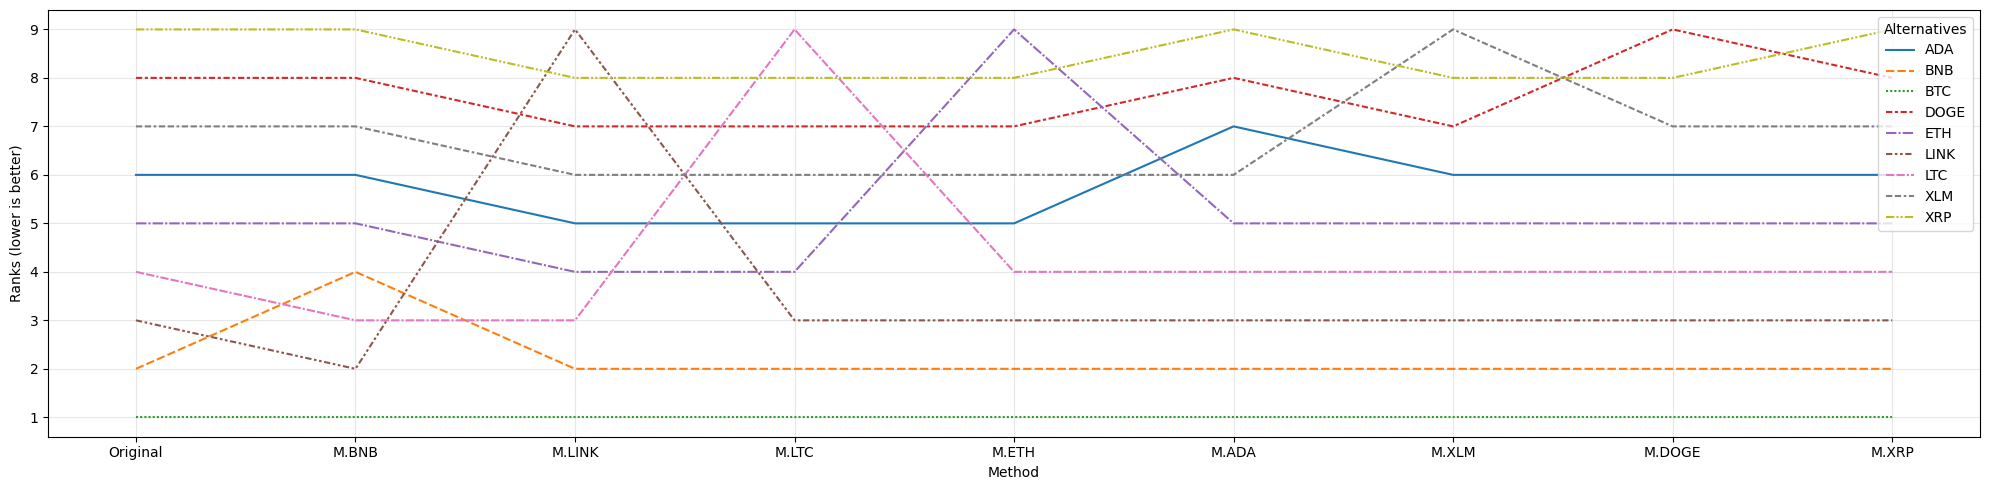

In [53]:
fig = plt.gcf()
fig.set_size_inches(20, 5)
rcmp.plot.flow()
fig.tight_layout();

## Reversión de rankings - Test #1

In [54]:
rcmp[1]

Alternatives  ADA  BNB  BTC  DOGE  ETH  LINK  LTC  XLM  XRP
Rank            6    4    1     8    5     2    3    7    9
[Method: TOPSIS+RRT1+BNB_0]

In [55]:
rcmp[1].e_

<extra {'similarity', 'anti_ideal', 'rrt1', 'ideal'}>

In [56]:
rcmp[1].e_.rrt1

<rrt1 {'noise', 'diff', 'mutated', 'iteration'}>

In [57]:
rcmp[1].e_.rrt1.noise

<bound method NDFrame.copy of Criteria
xRV   -5.417692e-03
sRV    5.266541e-03
xVV   -4.859664e+08
sVV    3.814603e+09
xR2   -7.251656e-03
xm    -7.400096e-09
Name: (BNB, LINK), dtype: float64>

## Reversión de rankings - Test #2

> La clasificación de las alternativas por un método MCDM eficaz debe seguir la propiedad de transitividad.

#### Idea:

- Supongamos que un método MCDM ha clasificado de alguna manera un conjunto de alternativas de un problema de decisión. 
- A continuación, supongamos que este problema se descompone en un conjunto de problemas más pequeños, cada uno definido sobre dos alternativas a la vez y el mismo número de criterios que en el problema original. 
- Entonces, según este criterio de prueba, todas las clasificaciones que se derivan de los problemas más pequeños deben satisfacer la propiedad de transitividad. 
- Es decir, si la alternativa $A_1$ es mejor que la alternativa $A_2$, y la alternativa $A_2$ es mejor que la alternativa $A_3$, entonces también hay que esperar que la alternativa $A_1$ sea mejor que la alternativa $A_3$.

## Reversión de rankings - Test #3

> Para el mismo problema de decisión y cuando se utiliza el mismo método MCDM, después de combinar las
clasificación de los problemas más pequeños en los que se descompone un problema MCDM, la nueva clasificación global de las alternativas debe ser idéntica a la clasificación global original del problema no descompuesto.

### Idea:

- Como en el caso anterior, supongamos que un problema MCDM se descompone en un conjunto de problemas más pequeños, cada uno de ellos definido sobre dos alternativas y los criterios de decisión originales. 
- A continuación, supongamos que las clasificaciones de los problemas más pequeños siguen la propiedad de transitividad.
- Según este criterio de prueba, cuando se combinan las clasificaciones de los problemas más pequeños la nueva clasificación global de las alternativas debe ser idéntica a la clasificación global original antes de la descomposición del problema.

## Análisis de sensibilidad

- Hasta ahora todos los experimentos se basaron en estudiar la función de utilidad de los criterios.
- Obviamente quedan preguntas sobre que como son los rankings obtenidos  dado que la importancia relativa de cada criterio de decisión **cambia**.
- O determinar cual alternativa es la mas determina en como se conforman el ranking.
- Estos dos test de sensibilidad fueron presentados en:

> Triantaphyllou, E., & Sánchez, A. (1997). A sensitivity analysis approach for some deterministic multi‐criteria decision‐making methods. Decision sciences, 28(1), 151-194.

## Análisis de sensibilidad - Problema 1

> Cuan ctítico es cada criterio, realizando un análisis de sensibilidad sobre sus ponderaciones, para determinar cuál es el cambio más pequeño en los pesos, que puede alterar la clasificación existente de las alternativas.

Para esto vale la pena derminar el **Criterio más critico**

- Intuitivamente el es el criterio con mayor peso, pero eso puede llevar a confusiones. 
- Pero es mejor encarar a esto como un problema de rank reversal, como plantea la definición anterior.


## Análisis de sensibilidad - Problema 2

> Determinación de la medida de desempeño más crítica $a_{ij}$

Análogo al caso del **Criterio más critico**

- Podemos ver cual valor en toda la matríz cambia en ranking (normalmente nos importa el primer lugar).

## GRACIAS.

Juan - jbcabral@unc.edu.ar

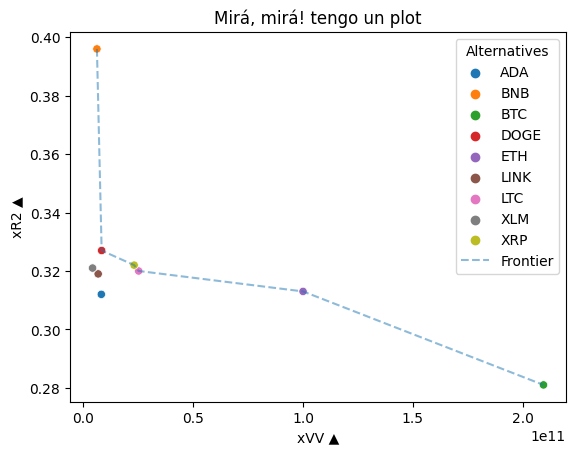

In [58]:
ax = dm.plot.frontier("xVV", "xR2");
ax.set_title("Mirá, mirá! tengo un plot");